# 減衰項付き強制振動のアジョイントコード

## -----------コードを書く前の下準備----------

## Reference (参考文献)

- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．
- 藤井陽介・碓氷典久・丹羽洋介，変分法データ同化と正定値対称行列，2014，http://www3.grips.ac.jp/~tsuchiya/PSD/slides/fujii140115.pdf

### Forced Oscillation with Decay (減衰項付き強制振動)

今回は，淡路他著の5.2節にある減衰項付き強制振動問題を考える．質点$m$の減衰項付き強制振動の支配方程式は以下である．
$$
\begin{align*}
&\frac{dx}{dt}=v\\
&m\frac{dv}{dt}=-kx-rv+w
\end{align*}
$$

ここで，$x$は質点の位置，$v$は速度，$k$は振動定数，$r$は減衰定数，$w$は強制力である．オイラーの前進差分を適用すると，次のように表せる．
$$
\begin{align*}
&x_{t+1}=x_t+\Delta tv_{t-1}\\
&v_{t+1}=-k\frac{\Delta t}{m}x_t+\left(1-r\frac{\Delta t}{m}\right)v_t+\frac{\Delta t}{m}w_t
\end{align*}
$$

今回，パラメータは既知のものとして，$m=1.0, k=0.5, r=0.75, \Delta t=1.0$として双子実験を行う．

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

今回は，真値（完全シミュレーション），シミュレーション値(シミュレーションで使うパラメータ),観測値を次のようにセットアップする．
- 真値：$x_0=5.0, v_0=0.0, w_t=\sin(2\pi t/10)$
- シミュレーション値 : $x_0=6.0, v_0=0.0, w_t=\sin(2\pi t/10)+q,\ q\sim N(0,0.5^2)$
- 観測値 : $y_t=x_t^{true}+\varepsilon,\ \varepsilon\sim N(0, 1)$（偶数時にのみ観測が得られるとする）

### アジョイント法

今回は，初期値$x_0$と強制力$w_t$に関する最適化を行うので，評価関数は，
$$J=\frac{1}{2}\frac{(x_0-x^{sim})^2}{(\sigma^b)^2}+\frac{1}{2}\sum_{t=0}^{T-1}\frac{(w_t-w^{sim})^2}{(\sigma^w)^2}+\sum_{t=1}^{[T/2]}\frac{(x_{2t}-y_{2t})^2}{(\sigma^o)^2}$$
として構成できる．すると，アジョイント数は次のように更新すれば良い．
$$
\begin{align}
&\lambda_t^x=\lambda_{t+1}^x-k\frac{\Delta t}{m}\lambda_{t+1}^v+\left\{\begin{array}{cl}(x_t-y_t)/(\sigma^o)^2&t\equiv0(mod\ 2),t\neq0\\0&t\equiv1(mod\ 2)\\(x_0-x^{sim})/(\sigma^b)^2&t=0\end{array}\right.\\
&\lambda_t^v=\Delta_t\lambda_{t+1}^x+\left(1-r\frac{\Delta t}{m}\right)\lambda_{t+1}^v\\
&\lambda_t^w=\frac{\Delta t}{m}\lambda_{t+1}^v+\frac{w_t-w_t^{sim}}{(\sigma^w)^2}
\end{align}
$$

すると，挿入値に関する評価関数の勾配は，$\partial J/\partial x_0^e=\lambda_0^x,\ \partial J/\partial w_t^e=\lambda_t^w$となる．勾配の大きさは，
$$|\mathbf{g}|=\sqrt{(\lambda_0^x)^2+\sum_{t=0}^{T-1}(\lambda_t^{w})^2}$$
として計算できる．

### 共役勾配法

共役直交性を利用して，次のように挿入変数を更新する．
$$
\begin{align}
&\beta_k=\frac{\mathbf{g}_k^T(\mathbf{g}_k-\mathbf{g}_{k-1})}{\mathbf{d}_{k-1}^T(\mathbf{g}_k-\mathbf{g}_{k-1})^T}\\
&\mathbf{d}_k=-\mathbf{g}_k+\beta_k\mathbf{d}_{k-1}\\
&\mathbf{x}_{k+1}=\mathbf{x}_k+\alpha_k\mathbf{d}_k
\end{align}
$$

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > try_and_error > Python_source : saving place for source
- DataAssimilation > try_and_error > plot : saving place for plot result

バージョンについて
- Mac OS 10.10
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1

In [1]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE

### 真値，観測値生成用関数

In [60]:
# Euler forward differential
def Euler_forward_differential (state, m, w, k, r, dt, t) :
    '''
    <Input Variables>
    state [n_dim] {float} : position and velocity (x, v) (位置と速度)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    t {int} : time (ステップ番号)
    
    <Variables>
    x {float} : position (位置)
    v {float} : velocity (速度)
    '''
    x = state[0]
    v = state[1]
    
    new_state = np.zeros(2)
    new_state[0] = x + dt * v
    new_state[1] = v + dt / m * (- k * x - r * v + w(t * dt))
    return new_state

# perfect simulation
def perfect_simulation (initial_state, m, w, k, r, dt, T) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_perf {float} : perfect forcing (外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    '''
    L = math.ceil(T / dt)
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_perf = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_perf[0] = w(0)
    for t in range(L) :
        state = Euler_forward_differential(state, m, w, k, r, dt, t)
        x[t + 1] = state[0]
        v[t + 1] = state[1]
        w_perf[t + 1] = w((t + 1) * dt)
    return x, v, w_perf

# observation (perfect simulation + noise)
def make_observation (initial_state, m, w, k, r, dt, T, sigma_obs) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x_obs {float} : position (位置)
    noise [n_dim] {float} : normal noise ~ N(0, sigma_obs**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt)
    x_obs = np.zeros(L + 1)
    x_obs[0] = initial_state[0]
    
    x_perf, _, _ = perfect_simulation(initial_state, m, w, k, r, dt, T)
    for t in range(1, L + 1) :
        if t%2 == 0 :
            noise = rd.normal(0, sigma_obs, size = 1)
            x_obs[t] = x_perf[t] + noise
        else :
            x_obs[t] = np.nan
    return x_obs

# simulation (perfect simulation + noise)
def make_simulation (initial_state, m, w, k, r, dt, T, sigma_w) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, sigma_w**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt)
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_sim = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_sim[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, sigma_w, size = 1)
        w_sim[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_sim

### 評価関数，モデル更新関数，アジョイント更新関数

In [97]:
def evaluation_function (x, y, w_update, x_background, w_background, sigma_bg, sigma_w, sigma_obs) :
    '''
    <Input Varibles>
    x [time] {float} : position x (位置x)
    y [time] {float} : observation y (観測y)
    w_update [time] {float} : force w (強制力w)
    x_background {float} : background value of system variable x (初期状態変数の背景値)
    w_background {float} : background value of force w (強制力wの背景値)
    sigma_bg {float} : background error (初期値の背景誤差)
    sigma_w {float} : background force error (強制力の背景誤差)
    sigma_obs {float} : observation error  (観測誤差)
    
    <Variables>
    L {int} : length of data (ステップ数)
    value {float} : evaluation value (評価関数値)
    new_x [time - 2] {float} : 時点2以降x
    new_y [time - 2] {float} : 時点2以降y
    '''
    L = len(y)
    value = 0
    
    # 初期値の背景誤差
    value += (x[0] - x_background)**2 / sigma_bg**2 / 2
    
    # 強制力の誤差
    value += np.dot(w_update - w_background, w_update.T - w_background.T) / sigma_w**2 / 2
    
    # 観測誤差
    new_x = x[2:]
    new_y = y[2:]
    value += np.dot(x[::2] - y[::2], x[::2].T - y[::2].T)
    
    return value


def model_update_function (state, wt, m, k, r, dt, t) :
    '''
    <Input Variables>
    state [n_dim] {float} : position, velocity (x, v) (位置，速度)
    wt {float} : force (強制力)
    m {float} : mass (質量)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    t {int} : time (ステップ番号)
    
    <Variables>
    x {float} : position (位置)
    v {float} : velocity (速度)
    '''
    x = state[0]
    v = state[1]

    state[0] = x + dt * v
    state[1] = v + dt / m * (- k * x - r * v + wt)
    return state


def adjoint_update_function (state, xt, yt, wt, wtb, m, k, r, dt, sigma_obs, sigma_w, even = True) :
    '''
    t = 0 のときは，
        sigma_obs ->　sigma_background
        xt -> x0
        yt -> x_background
        even -> True
    とすれば良い．
    
    <Input Variables>
    state [n_dim] {float} : adjoint state (lambda^x, lambda^v, lambda^w) (アジョイント変数)
    xt {float} : state variable x (状態変数の位置x_t)
    yt {float} : observation variable y (観測y_t)
    wt {float} : force variable w (強制力w_t)
    wtb {float} : background value of force w (強制力w_tの背景値)
    m {float} : mass (質量)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    sigma_obs {float} : standard deviation of observation (観測誤差)
    sigma_w {float} : standard deviation of force (強制力の誤差)
    even {boolean} : even or odd (偶奇)
    
    <Variables>
    ax {float} : adjoint position lambda_x (アジョイント変数lambda_x)
    av {float} : adjoint velocity lambda_v (アジョイント変数lambda_v)
    aw {float} : adjoint force lambda_w (アジョイント変数lambda_w)
    '''
    ax = state[0]
    av = state[1]
    
    new_state = np.zeros(3)
    
    if even :
        new_state[0] = ax - k * dt / m * av + (xt - yt) / sigma_obs**2
    else :
        new_state[0] = ax - k * dt / m * av
    new_state[1] = dt * ax + (1 -  r * dt / m) * av
    new_state[2] = dt / m * av + (wt - wtb) / sigma_w**2
    
    return new_state

### アジョイント法のクラス作成

最適化アルゴリズムとしては勾配降下法を用いた．共役勾配法は発散してしまっため

In [91]:
class Adjoint_Method (object) :
    '''
    <Input Variables>
    y [time, n_dim_obs] {float} : observation data (観測値)
    n_epoch {int}: number of epochs for gradient descent (エポック数)
    n_dim_sys {int} : dimension of system x (状態変数の次元)
    initial_x [n_dim_sys] {float} : initial system x (adjusting parameter) (初期状態変数)
    x_background {float} : background value of system variable x (初期状態変数の背景値)
    w_background {float} : background value of force w (強制力wの背景値)
    sigma_bg {float} : background error (初期値の背景誤差)
    sigma_w {float} : background force error (強制力の背景誤差)
    sigma_obs {float} : observation error  (観測誤差)
    evaluation_function {function} : model evaluation function (評価関数)
    model_update_function {function} : model update function of system variables (x,v) (時間方向更新関数)
    adjoint_update_function {function} : adjoint update function of adjoint variables lambda(x,v,w) (アジョイント更新関数)
    w_initial [time] {float} : forcing w (強制力の初期値)
    m {float} : mass (質量)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間差分幅)
    alpha {float} : learning rate of gradient method (勾配法の学習率)
    
    <Variable>
    w_update [time] {float} : forcing w (強制力)
    evaluation [n_epoch] {float} : evaluation function value (評価関数の値)
    gradient_abs [n_epoch] {float} : gradient absolute value (勾配の大きさ)
    '''
    def __init__(self, y = None, n_epoch = 20,  initial_x = None, x_background = None, w_background = None,
                 sigma_bg = 0.1, sigma_w = 0.1, sigma_obs = 0.1, evaluation_function = evaluation_function,
                 model_update_function = model_update_function, adjoint_update_function = adjoint_update_function,
                 w_initial = None, m = 1, k = 1, r = 1, dt = 1, alpha = 0.01, n_dim_sys = None) :
        self.y = y
        self.n_epoch = n_epoch
        self.initial_x = initial_x
        self.n_dim_sys = n_dim_sys
        self.x_background = x_background
        self.w_background = w_background
        self.sigma_bg = sigma_bg
        self.sigma_w = sigma_w
        self.sigma_obs =sigma_obs
        self.evaluation_function = evaluation_function
        self.model_update_function = model_update_function
        self.adjoint_update_function = adjoint_update_function
        self.w_update = w_initial
        self.m = m
        self.k = k
        self.r = r
        self.dt = dt
        self.alpha = alpha
    
    def _conjugate_gradient_method (self, d_before, g, g_before) :
        '''
        共役勾配法
        今回は d_before と g - g_before の内積が発散してしまうためやめとく
        d_before {float} : 1 step before d (1ステップ前のd，行ベクトル)
        g {float} : gradient (勾配, 行ベクトル)
        g_before {float} : 1 step before g (1ステップ前の勾配g, 行ベクトル)
        beta {float} : parameter (方向探索用パラメータ)
        '''
        beta = np.dot(g.T, g - g_before) / np.dot(d_before.T, g - g_before)
        return - g + beta * d_before
    
    def simulate(self) :
        '''
        <Variables>
        L {int} : step number for time (ステップ数)
        x [time, n_dim_sys] {float} : system state of each time (システム変数)
        adjoint [n_dim + 1] {float} : adjoint variable lambda (x, v, w) (アジョイント変数)
        g [time + 1] {float} : gradient of evaluation function (勾配)
        d {float} : search vector (勾配法の探索方向)
        '''
        L = len(self.y)
        self.x = np.zeros((L, self.n_dim_sys))
        self.x[0] = self.initial_x
        self.evaluation = np.zeros(self.n_epoch)
        self.gradient_abs = np.zeros(self.n_epoch)
        g = np.zeros(L + 1)
        #g_before = np.zeros(L + 1)
        #d = np.zeros(L + 1)
        adjoint = np.zeros(3)
        
        for i in range(self.n_epoch) :
            # print epoch number
            print('\r epoch :', i + 1, '/' , self.n_epoch, end = '')
            
            # 前の勾配を入れておく
            #g_before = g
            
            # model forward
            for t in range(L - 1) :
                self.x[t + 1] = self.model_update_function(self.x[t], self.w_update[t], self.m, self.k, self.r, self.dt, t)
            
            # adjoint backward
            for t in list(reversed(range(L))) :
                if t == 0 :
                    adjoint = self.adjoint_update_function(adjoint, self.x[t, 0], self.x_background, self.w_update[t], self.w_background[t], 
                                                           self.m, self.k, self.r, self.dt, self.sigma_bg, self.sigma_w)
                elif t%2 == 0:
                    adjoint = self.adjoint_update_function(adjoint, self.x[t, 0], self.y[t], self.w_update[t], self.w_background[t], 
                                                           self.m, self.k, self.r, self.dt, self.sigma_obs, self.sigma_w)
                else :
                    adjoint = self.adjoint_update_function(adjoint, self.x[t, 0], self.y[t], self.w_update[t], self.w_background[t], 
                                                           self.m, self.k, self.r, self.dt, self.sigma_obs, self.sigma_w, False)
                g[t + 1] = adjoint[2]
            
            # 勾配と探索方向，評価関数
            g[0] = adjoint[0]
            self.gradient_abs[i] = np.linalg.norm(g)
            self.evaluation[i] = self.evaluation_function(self.x[:, 0], self.y, self.w_update, self.x_background, self.w_background, 
                                                          self.sigma_bg, self.sigma_w, self.sigma_obs)
            
            d = - g
            '''
            # 共役勾配法
            if i == 0:
                d = - g
            else :
                d = self._conjugate_gradient_method(d, g, g_before)
            '''
            
            # 挿入変数の更新
            self.x[0] = self.x[0] + self.alpha * d[0]
            self.w_update = self.w_update + self.alpha * d[1:]
        
        # model forward (prediction)
        for t in range(L - 1) :
            self.x[t + 1] = self.model_update_function(self.x[t], self.w_update[t], self.m, self.k, self.r, self.dt, t)
    
    # get adjoint value (位置，速度が得られる)
    def get_adjoint_value (self, dim = 0) :
        return self.x[:, dim]
    
    # get force value (外力が得られる)
    def get_force_value (self) :
        return self.w_update
    
    # get evaluation value (評価関数が得られる)
    def get_evaluation_value (self) :
        return self.evaluation
    
    # get gradient absotute value (勾配の大きさが得られる)
    def get_gradient_absolute_value (self) :
        return self.gradient_abs

### 実行フェイズ

In [12]:
# forcing function
def w (t) :
    '''
    <Input Variable>
    t {float} : time
    '''
    return np.sin(np.pi * t / 5)

In [105]:
# decide parameters
n_epoch = 500
n_dim_sys = 2
n_dim_obs = 1
perf_initial = np.array([5.0, 0.0])
sim_initial = np.array([6.0, 0.0])
obs_initial = perf_initial
m = 1.0
k = 0.5
r = 0.75
dt = 1
sigma_bg = 1.0
sigma_w = 0.5
sigma_obs = 1.0
T = 100
alpha = 0.01
n_dim_sys = 2

In [39]:
w_initial = np.zeros(T + 1)
for t in range(T + 1) :
    w_initial[t] = w(t)

In [40]:
print(w_initial.shape)

(101,)


観測値，真値の生成

In [61]:
x_perf, v_perf, w_perf = perfect_simulation(perf_initial, m, w, k, r, dt, T)
x_obs = make_observation(obs_initial, m, w, k, r, dt, T, sigma_obs)
x_sim, v_sim, w_sim = make_simulation(sim_initial, m, w, k, r, dt, T, sigma_w)

In [35]:
print(x_perf.shape)
print(x_obs.shape)
print(x_sim.shape)

(101,)
(101,)
(101,)


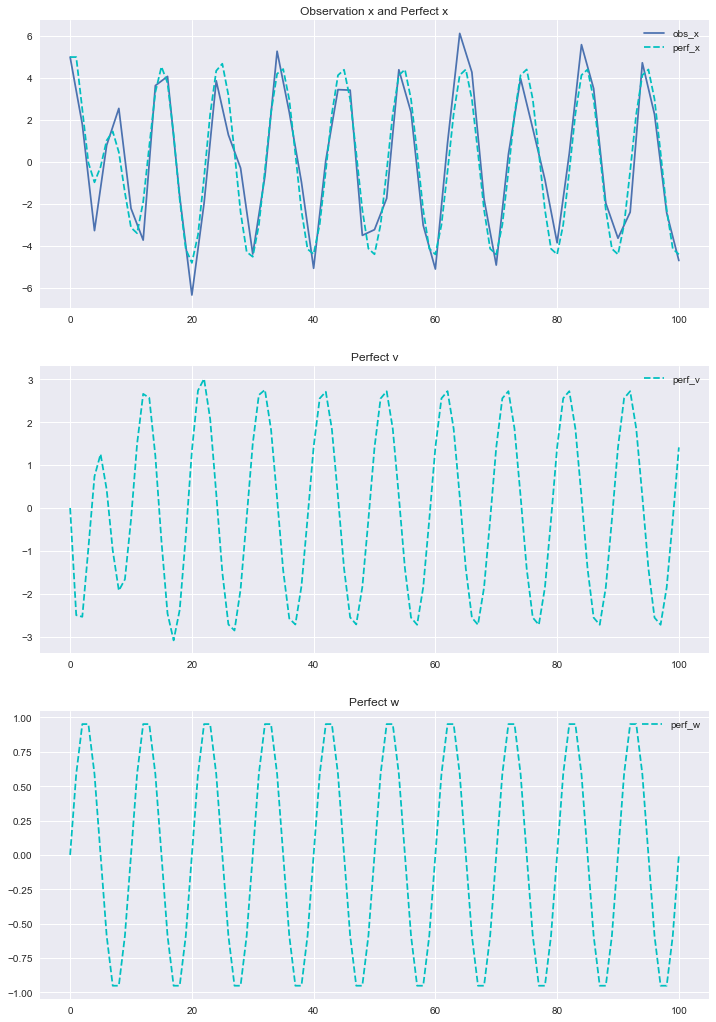

In [62]:
plt.figure(figsize = (12, 18))
plt.subplot(3, 1, 1)
plt.plot(range(0, len(x_obs), 2), x_obs[::2], label = 'obs_x')
plt.plot(x_perf, linestyle = '--', color = 'c', label = 'perf_x')
plt.title("Observation x and Perfect x")
plt.legend(loc = 'best')

plt.subplot(3, 1, 2)
plt.plot(v_perf, linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Perfect v")
plt.legend(loc = 'best')

plt.subplot(3, 1, 3)
plt.plot(w_perf, linestyle = '--', color = 'c', label = 'perf_w')
plt.title("Perfect w")
plt.legend(loc = 'best')
plt.show()

割と観測値にばらつきをもたせている

In [63]:
print(x_obs[:10])

[ 5.                 nan  1.7902607          nan -3.273924           nan
  0.79340317         nan  2.55289139         nan]


In [106]:
am = Adjoint_Method(x_obs , n_epoch,  sim_initial , x_sim[0], w_sim, sigma_bg, sigma_w, sigma_obs, evaluation_function,
                 model_update_function, adjoint_update_function, w_initial, m, k, r, dt, alpha, n_dim_sys)
am.simulate()

 epoch : 500 / 500 332 / 500 428 / 500

### 結果の表示

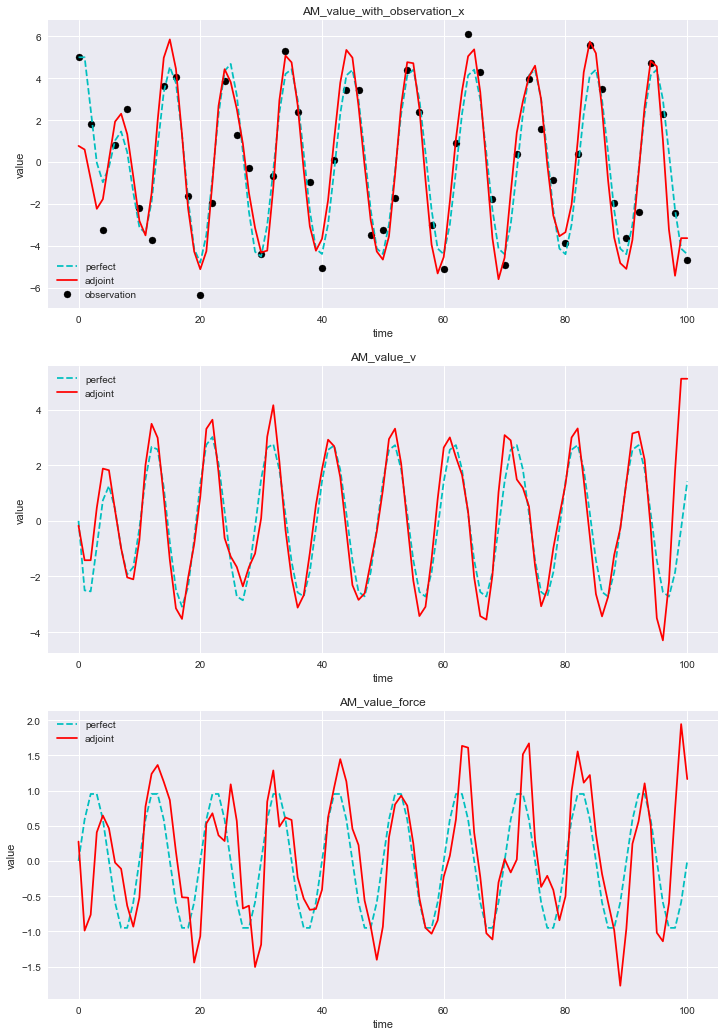

In [107]:
L = len(x_obs)

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
plt.scatter(range(0, L, 2), x_obs[::2], color = "k", marker = 'o', label = "observation")
plt.plot(range(L), x_perf, color = 'c', linestyle = '--', label = 'perfect')
plt.plot(am.get_adjoint_value(0), color = 'r', label =  'adjoint')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("AM_value_with_observation_x")

plt.subplot(3, 1, 2)
plt.plot(range(L), v_perf, color = 'c', linestyle = '--', label = 'perfect')
plt.plot(am.get_adjoint_value(1), color = 'r', label = 'adjoint')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("AM_value_v")

plt.subplot(3, 1, 3)
plt.plot(range(L), w_perf, color = 'c', linestyle = '--', label = 'perfect')
plt.plot(am.get_force_value(), color = 'r', label = 'adjoint')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("AM_value_force")

plt.savefig("../plot/171210_AM_position_velocity_force.png")
plt.show()

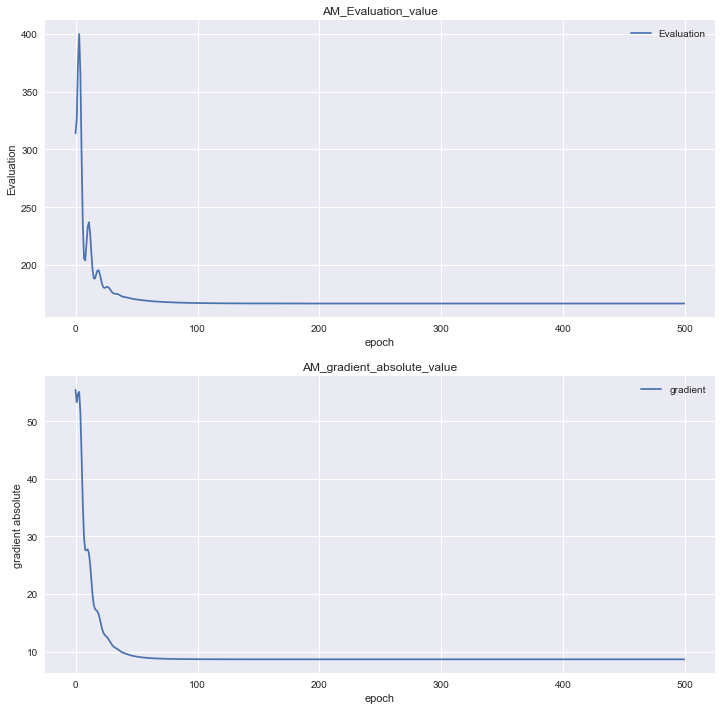

In [108]:
plt.figure(figsize = (12, 12))

plt.subplot(2, 1, 1)
plt.plot(am.get_evaluation_value(), label = 'Evaluation')
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Evaluation')
plt.title("AM_Evaluation_value")

plt.subplot(2, 1, 2)
plt.plot(am.get_gradient_absolute_value(), label = 'gradient')
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.ylabel('gradient absolute')
plt.title("AM_gradient_absolute_value")

plt.savefig("../plot/171210_AM_evaluation_gradient_absolute.png")
plt.show()

もう下がらないだろう

### 結果の評価(MSE, RMSE)

In [109]:
mse = np.zeros((1, 3))
mse[0, 0] = MSE(x_perf, am.get_adjoint_value(0))
mse[0, 1] = MSE(v_perf, am.get_adjoint_value(1))
mse[0, 2] = MSE(w_perf, am.get_force_value())
df_mse = pd.DataFrame(mse, index = ['Adjoint Method'], columns = ['x', 'v', 'w'])
df_mse

,x,v,w
Adjoint Method,1.49884,1.039999,0.439543


In [110]:
rmse = np.sqrt(mse)
df_rmse = pd.DataFrame(rmse, index = ['Adjoint Method'], columns = ['x', 'v', 'w'])
df_rmse

,x,v,w
Adjoint Method,1.224271,1.019804,0.662981


### 考察・感想

- 共役勾配法が発散，準ニュートン法メモリ確保どうしようとなって結局最急降下法になってしまった．
- 最急降下法だからか評価関数が50ぐらいまでしか下がっていない．それとも別の要因なのか．
- カルマンスムーザーに結果が負けているというのは解せない．線形モデルなら同じような結果が得られるはず．
- 昨日のカルマンでは，観測の生成方法が少し本と違っていたせいからなのか．それにしても本ではAdjoint 0.7までRMSE落ちていたはずなのに
- というわけでまた試行錯誤が必要になりそう